# Deep Learning Prediction Workflow
Predict daily household electricity consumption from weather + recent usage.
Trains three sequence models (LSTM, GRU, temporal CNN), visualizes performance, and saves artifacts.


In [1]:
%pip install -q torch pandas scikit-learn matplotlib seaborn joblib kaggle holidays
# Uncomment above if your environment is missing dependencies


In [2]:
import os
import subprocess
from pathlib import Path

GITHUB_URL = "https://github.com/HolikGellert/Projektmunka.git"
REPO_PATH = "/content/Projektmunka"

print("Setting up repository from GitHub...")

if not os.path.exists(REPO_PATH):
    # Clone if it doesn't exist
    print(f"Cloning from {GITHUB_URL}...")
    subprocess.run(["git", "clone", GITHUB_URL, REPO_PATH], check=True)
    print(f"✓ Cloned to {REPO_PATH}")
else:
    # Pull latest changes if it already exists
    print(f"Repository already exists at {REPO_PATH}")
    print("Pulling latest changes...")
    subprocess.run(["git", "-C", REPO_PATH, "pull"], check=True)
    print("✓ Pulled latest changes")

# Verify the structure
print(f'\n=== Repo structure ===')
repo_root = Path(REPO_PATH)

# Find prediction/ directory
prediction_dir = repo_root / 'prediction'
if prediction_dir.is_dir():
    print(f'✓ Found prediction/ at {prediction_dir}')
    print(f'  Config: {(prediction_dir / "config.py").is_file()}')
    print(f'  src/: {(prediction_dir / "src").is_dir()}')
else:
    # Search recursively
    found = False
    for root, dirs, files in os.walk(REPO_PATH):
        if 'prediction' in dirs:
            print(f'✓ Found prediction/ at {root}/prediction')
            found = True
            break
    if not found:
        print('✗ prediction/ directory not found')

Setting up repository from GitHub...
Repository already exists at /content/Projektmunka
Pulling latest changes...
✓ Pulled latest changes

=== Repo structure ===
✓ Found prediction/ at /content/Projektmunka/prediction
  Config: True
  src/: True


In [3]:
import sys
import os
from pathlib import Path

# Search for prediction/ directory starting from /content
REPO_ROOT = None

# Check multiple possible locations
search_paths = [
    Path('/content/Projektmunka'),
    Path('/content/Projektmunka/Projektmunka'),
    Path('/content'),
]

print('Searching for prediction/ directory...')
for search_path in search_paths:
    if search_path.exists():
        print(f'  Checking {search_path}...', end=' ')
        if (search_path / 'prediction').is_dir():
            REPO_ROOT = search_path
            print('✓ Found!')
            break
        else:
            print('✗')

if REPO_ROOT is None:
    # List what's actually in /content
    print('\n✗ Could not find prediction/ directory')
    print('\nContents of /content:')
    if Path('/content').exists():
        for item in os.listdir('/content'):
            item_path = Path('/content') / item
            marker = '📁' if item_path.is_dir() else '📄'
            print(f'  {marker} {item}')
    raise RuntimeError(
        'prediction/ directory not found.\n'
        'The Git clone may have created a different structure.\n'
        'Check the output above to see what was actually cloned.'
    )

print(f'\n✓ Repo root: {REPO_ROOT}')
print(f'✓ Prediction dir: {(REPO_ROOT / "prediction").is_dir()}')
print(f'✓ Config file: {(REPO_ROOT / "prediction" / "config.py").is_file()}')

# Add to sys.path
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
print(f'✓ CUDA available: {torch.cuda.is_available()}')

Searching for prediction/ directory...
  Checking /content/Projektmunka... ✓ Found!

✓ Repo root: /content/Projektmunka
✓ Prediction dir: True
✓ Config file: True
✓ CUDA available: True


In [4]:
import subprocess
from pathlib import Path
import shutil

print('=== Setting up data from GitHub LFS ===\n')

# Ensure Git LFS is available
print('Checking for Git LFS...')
try:
    result = subprocess.run(['git', 'lfs', '--version'], capture_output=True, text=True)
    print(f'✓ {result.stdout.strip()}')
except FileNotFoundError:
    print('⚠ Git LFS not found. Installing...')
    subprocess.run(['apt-get', 'update'], capture_output=True)
    subprocess.run(['apt-get', 'install', '-y', 'git-lfs'], capture_output=True)
    subprocess.run(['git', 'lfs', 'install'], check=True)
    print('✓ Git LFS installed')

# Pull LFS files from the cloned repo
repo_root = Path('/content/Projektmunka')
print(f'\nPulling LFS files from {repo_root}...')

try:
    subprocess.run(['git', '-C', str(repo_root), 'lfs', 'pull'], 
                   capture_output=True, text=True, timeout=120, check=True)
    print('✓ Git LFS pull completed')
except subprocess.CalledProcessError as e:
    print(f'⚠ Git LFS pull warning: {e.stderr}')
    print('  Attempting to continue anyway...')

# Look for CSV files in the cloned repo
print('\n=== Looking for CSV files in repo ===')
search_dirs = [
    repo_root / 'prediction' / 'data',
    repo_root / 'data' / 'raw',
    repo_root / 'data',
]

found_daily = None
found_weather = None

for search_dir in search_dirs:
    if search_dir.exists():
        daily_f = search_dir / 'daily_dataset.csv'
        weather_f = search_dir / 'london_weather.csv'
        if daily_f.exists():
            found_daily = daily_f
            print(f'✓ Found daily_dataset.csv in {search_dir.relative_to(repo_root)}')
        if weather_f.exists():
            found_weather = weather_f
            print(f'✓ Found london_weather.csv in {search_dir.relative_to(repo_root)}')

if found_daily is None or found_weather is None:
    print('\n✗ Could not find CSV files')
    print('Missing:')
    if found_daily is None:
        print('  - daily_dataset.csv')
    if found_weather is None:
        print('  - london_weather.csv')
    raise FileNotFoundError('CSV files not found in GitHub repo')

# Copy to working directory
print('\n=== Copying to working directory ===')
data_dir = repo_root / 'prediction' / 'data'
data_dir.mkdir(parents=True, exist_ok=True)

for src_file in [found_daily, found_weather]:
    if src_file and src_file.exists():
        dst_file = data_dir / src_file.name
        # Only copy if not already in the target location
        if str(src_file) != str(dst_file):
            shutil.copy2(str(src_file), str(dst_file))
            print(f'✓ Copied {src_file.name}')
        else:
            print(f'✓ {src_file.name} already in place')
        size_mb = dst_file.stat().st_size / (1024**2)
        print(f'  Size: {size_mb:.1f} MB')

print('\n✓ Data setup complete!')


=== Setting up data from GitHub LFS ===

Checking for Git LFS...
✓ git-lfs/3.0.2 (GitHub; linux amd64; go 1.18.1)

Pulling LFS files from /content/Projektmunka...
✓ Git LFS pull completed

=== Looking for CSV files in repo ===
✓ Found daily_dataset.csv in prediction/data
✓ Found london_weather.csv in prediction/data
✓ Found daily_dataset.csv in data/raw
✓ Found london_weather.csv in data/raw

=== Copying to working directory ===
✓ Copied daily_dataset.csv
  Size: 97.3 MB
✓ Copied london_weather.csv
  Size: 0.8 MB

✓ Data setup complete!


In [ ]:
# Mount Google Drive (Colab) and define checkpoint/final directories
from pathlib import Path
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

DRIVE_ROOT = Path('/content/drive/MyDrive/Projektmunka')
CHECKPOINT_DIR = DRIVE_ROOT / 'checkpoints'
FINAL_MODEL_DIR = DRIVE_ROOT / 'models'

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
    FINAL_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print('Drive mounted. Checkpoints ->', CHECKPOINT_DIR)
else:
    print('Not running in Colab; Drive mount skipped.')


## Data prep
Merge energy + weather, add temporal features, scale, and build sliding-window sequences for the models.


In [5]:
from prediction.config import PredictionConfig as Config
from prediction.src.data_prep import PredictionDataPrep

prep = PredictionDataPrep()
merged_df = prep.add_features(prep.load_raw())
seq_data = prep.build_sequences(merged_df)

# Chronological split; scaler is fit on train sequences inside the split helper
X_train, X_val, X_test, y_train, y_val, y_test = prep.train_val_test_split(seq_data)

print('Merged shape:', merged_df.shape)
print('Sequence tensor:', seq_data.X.shape)
print('Train/Val/Test:', X_train.shape, X_val.shape, X_test.shape)
print('Scaler fitted on train split:', seq_data.scaler is not None)


Merged shape: (3498239, 26)
Sequence tensor: (3381518, 21, 16)
Split sizes: 2705216 338151 338151


## Build dataloaders
Splits sequences into train/validation sets.


In [6]:
from prediction.src.train_utils import create_dataloaders, save_scaler, make_loader

train_loader, val_loader = create_dataloaders(X_train, y_train, X_val, y_val, batch_size=Config.BATCH_SIZE)
test_loader = make_loader(X_test, y_test, batch_size=Config.BATCH_SIZE, shuffle=False)

# Persist the scaler fitted on the training split for consistent inference
assert seq_data.scaler is not None, 'Scaler should be set after splitting'
save_scaler(seq_data.scaler)
len(train_loader), len(val_loader), len(test_loader)


(10568, 1321, 1321)

## Train models
Train an LSTM, GRU, and temporal CNN; log histories and persist weights.


In [7]:
from prediction.src.models import LSTMRegressor, GRURegressor, TemporalCNNRegressor
from prediction.src.train_utils import train_model, save_model, save_metadata, evaluate_mae
import torch

input_size = len(seq_data.feature_cols)
models = {
    'lstm': (LSTMRegressor(input_size=input_size), Config.LSTM_MODEL_PATH),
    'gru': (GRURegressor(input_size=input_size), Config.GRU_MODEL_PATH),
    'tcn': (TemporalCNNRegressor(input_size=input_size), Config.CNN_MODEL_PATH),
}

def save_checkpoint(name, model, epoch):
    if not IN_COLAB:
        return
    CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
    ckpt_path = CHECKPOINT_DIR / f'{name}_checkpoint.pt'
    state = {k: (v.cpu() if torch.is_tensor(v) else v) for k, v in model.state_dict().items()}
    torch.save({'model_state': state, 'epoch': epoch}, ckpt_path)
    print(f"[CKPT] Saved {ckpt_path} at epoch {epoch}")

def load_checkpoint_if_exists(name, model):
    ckpt_path = CHECKPOINT_DIR / f'{name}_checkpoint.pt'
    if IN_COLAB and ckpt_path.exists():
        state = torch.load(ckpt_path, map_location=torch.device('cpu'))
        model.load_state_dict(state.get('model_state', state))
        start_epoch = int(state.get('epoch', 0))
        print(f"[CKPT] Resumed {name} from epoch {start_epoch}")
        return model, start_epoch, ckpt_path
    return model, 0, ckpt_path

histories = {}
metrics = {}

for name, (model, path) in models.items():
    model, start_epoch, ckpt_path = load_checkpoint_if_exists(name, model)
    epochs_remaining = max(Config.EPOCHS - start_epoch, 0)
    if epochs_remaining == 0:
        print(f"{name} already trained for {start_epoch} epochs; skipping training run.")
        history = {'train_loss': [], 'val_loss': []}
    else:
        def _checkpoint_cb(epoch, m=model, nm=name):
            if epoch % 10 == 0:
                save_checkpoint(nm, m, epoch)

        history = train_model(
            model,
            train_loader,
            val_loader,
            epochs=epochs_remaining,
            lr=Config.LEARNING_RATE,
            weight_decay=Config.WEIGHT_DECAY,
            grad_clip=Config.GRAD_CLIP,
            max_batches=Config.MAX_TRAIN_BATCHES,
            early_stop_patience=Config.EARLY_STOP_PATIENCE,
            start_epoch=start_epoch,
            checkpoint_fn=_checkpoint_cb if IN_COLAB else None,
        )
    val_mae = evaluate_mae(model, val_loader, max_batches=Config.MAX_EVAL_BATCHES)
    test_mae = evaluate_mae(model, test_loader, max_batches=Config.MAX_EVAL_BATCHES)

    # Save final artifacts: Drive (final) and repo-local copy
    if IN_COLAB:
        FINAL_MODEL_DIR.mkdir(parents=True, exist_ok=True)
        final_path = FINAL_MODEL_DIR / f'{name}_final.pt'
        save_model(model, final_path)
        if ckpt_path.exists():
            ckpt_path.unlink()
            print(f"[CKPT] Removed {ckpt_path} after saving final model.")
    save_model(model, path)

    histories[name] = history
    metrics[name] = {'val_mae': val_mae, 'test_mae': test_mae}

metadata = {
    'feature_cols': seq_data.feature_cols,
    'lookback': seq_data.lookback,
    'metrics': metrics,
}
save_metadata(metadata)
metrics



Training LSTM...
Epoch 1/1 - train_loss=12.5535 val_loss=10.6186

Training GRU...
Epoch 1/1 - train_loss=12.1961 val_loss=10.8477

Training TCN...
Epoch 1/1 - train_loss=15.9725 val_loss=14.8626


{'lstm': {'val_mae': 1.8877729177474976, 'test_mae': 1.9921218156814575},
 'gru': {'val_mae': 1.8989641666412354, 'test_mae': 2.0059361457824707},
 'tcn': {'val_mae': 2.2600953578948975, 'test_mae': 2.3679206371307373}}

## Plot training curves


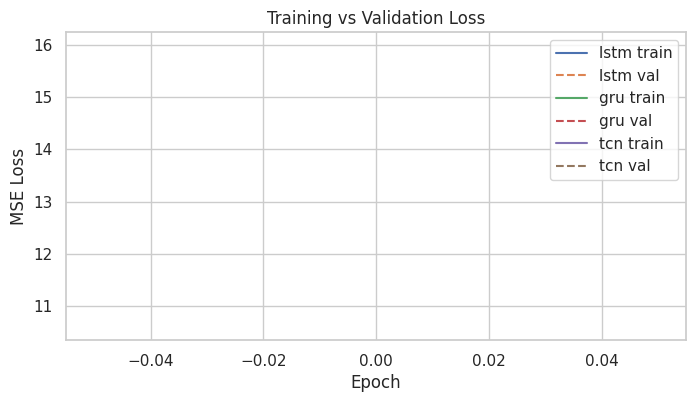

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))
for name, hist in histories.items():
    ax.plot(hist['train_loss'], label=f'{name} train')
    ax.plot(hist['val_loss'], linestyle='--', label=f'{name} val')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.legend()
ax.set_title('Training vs Validation Loss')
plt.show()


## Inspect predictions
Visual sanity check on a validation batch.


Model device: cuda:0


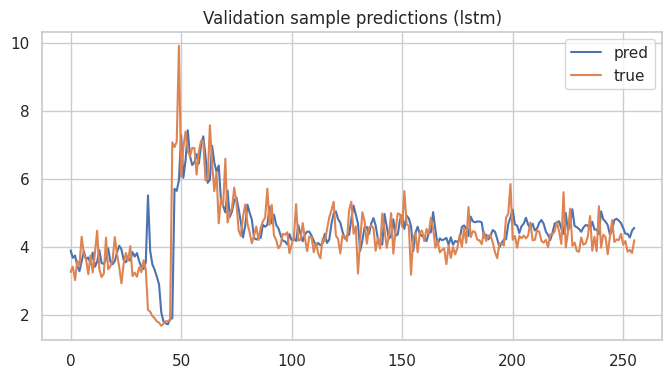

In [11]:
# Choose best model based on validation MAE and visualize a batch
model_key = min(metrics, key=lambda k: metrics[k]['val_mae'])
best_model = models[model_key][0]
best_model.eval()

# Get device from model
device = next(best_model.parameters()).device
print(f'Model device: {device}')

batch_X, batch_y = next(iter(val_loader))
# Move batch to same device as model
batch_X = batch_X.to(device)
batch_y = batch_y.to(device)

with torch.no_grad():
    preds = best_model(batch_X).squeeze().cpu().numpy()
truth = batch_y.squeeze().cpu().numpy()

plt.figure(figsize=(8, 4))
plt.plot(preds, label='pred')
plt.plot(truth, label='true')
plt.title(f'Validation sample predictions ({model_key})')
plt.legend()
plt.show()


## Inspect test predictions
Quick visual check of the best model on a test batch.


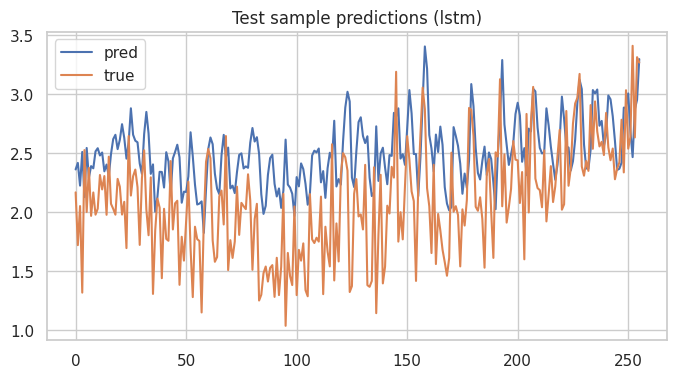

In [12]:
# Visualize a batch from the held-out test set
batch_X_test, batch_y_test = next(iter(test_loader))
batch_X_test = batch_X_test.to(device)
batch_y_test = batch_y_test.to(device)

with torch.no_grad():
    test_preds = best_model(batch_X_test).squeeze().cpu().numpy()
test_truth = batch_y_test.squeeze().cpu().numpy()

plt.figure(figsize=(8, 4))
plt.plot(test_preds, label='pred')
plt.plot(test_truth, label='true')
plt.title(f'Test sample predictions ({model_key})')
plt.legend()
plt.show()
